# Testing VGG-19
A tutorial to test LeNet-5 using ADAPT. This tutorial notebook is created with Ubuntu machine with Intel(R) i7-9700, GeForce RTX-2080, and 16GB of memory. Before start tutorial, if you use your GPU, the following cell will set tensorflow to use minimal memory.

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## Load model to test
The pre-trained VGG-19 is offered by Tensorflow/Keras. You can easily download the pre-trained model using Tensorflow/Keras.

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19

In [3]:
model = VGG19()
model.summary()

574717952/574710816 [==============================] - 53s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

## Test using ADAPT
From now on, let's test the created model.

### 1. Choose candidate input
This tutorial offers some example images in ```data/imagenet``` folder.

In [4]:
from pathlib import Path
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

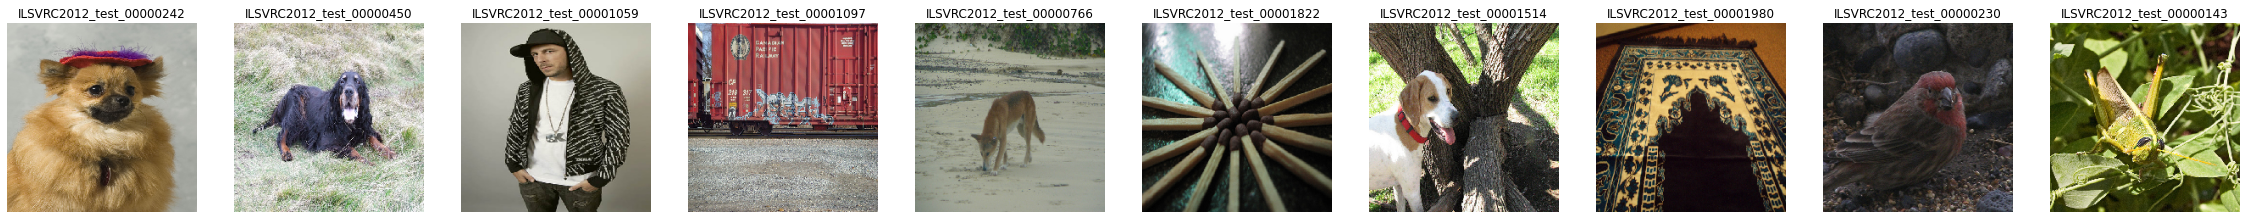

In [5]:
path = Path('data/imagenet/')
paths = list(path.glob('*.JPEG'))
images = [image.load_img(p, target_size=(224, 224)) for p in paths]
images = [image.img_to_array(i) for i in images]
fig, ax = plt.subplots(1, len(images), figsize=(len(images) * 4, 4))
for i, img in enumerate(images):
    ax[i].set_axis_off()
    ax[i].title.set_text(paths[i].stem)
    ax[i].imshow(img.astype(int))
plt.show()

Finally, preprocess the input using provided preprocess function.

In [6]:
images = [preprocess_input(i) for i in images]

Now our input image is ready!

### 2. Create a fuzzer
ADAPT offers various modules (e.g. coverage metrics and neuron selection strategies) that can be used to compose a fuzzer. First thing to do is wrapping Keras model, since all modules in ADAPT use a Keras model wrapped with the ```adapt.Network``` class.

In [7]:
from adapt import Network

In [8]:
network = Network(model)

Create a tok-k neuron coverage with 30 as k value.

In [9]:
from adapt.metric import TKNC

In [10]:
metric = TKNC(30)

Create an adaptive and parameterized neuron selection strategy introduced in the following paper:

    Effective White-Box Testing of Deep Neural Networks with Adaptive Neuron-Selection Strategy
    
Note that the selection strategies and the fuzzers are created for each indivisual input.

In [11]:
from adapt.strategy import AdaptiveParameterizedStrategy
from adapt.fuzzer import WhiteBoxFuzzer
from tensorflow.keras.applications.vgg19 import decode_predictions

In [12]:
fuzzers_adapt = []
for image in images:
    strategy = AdaptiveParameterizedStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy, lr=10, decode=lambda x: decode_predictions(x)[0][0][1])
    fuzzers_adapt.append(fuzzer)

For comparision, fuzzers with random strategy, which selects neurons randomly, are used.

In [13]:
from adapt.strategy import RandomStrategy

In [14]:
fuzzers_rand = []
for image in images:
    strategy = RandomStrategy(network)
    fuzzer = WhiteBoxFuzzer(network, image, metric, strategy, lr=10, decode=lambda x: decode_predictions(x)[0][0][1])
    fuzzers_rand.append(fuzzer)

### 3. Start testing
Each input is tested for 20 minutes (200 minutes in total for one strategy), and keep the generated inputs with minimum distances.

In [15]:
from datetime import datetime

In [16]:
print('Fuzzing with adaptive parameterized strategy started at {}.'.format(datetime.now()))
archives_adapt = [fuzzer.start(minutes=20, append='min_dist') for fuzzer in fuzzers_adapt]
print('Done')

Fuzzing with adaptive parameterized strategy started at 2020-07-03 01:37:57.338538.
40960/35363 [==================================] - 0s 1us/step
Done


In [17]:
print('Fuzzing with random strategy started at {}.'.format(datetime.now()))
archives_rand = [fuzzer.start(minutes=20, append='min_dist') for fuzzer in fuzzers_rand]
print('Done')

Fuzzing with random strategy started at 2020-07-03 04:58:00.792481.
Done


### 4. Testing result
Here is the coverage graph.

In [18]:
import numpy as np

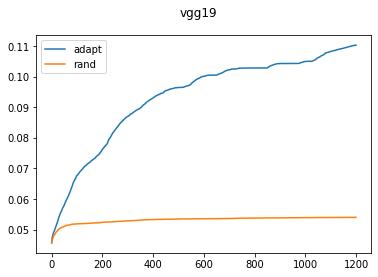

In [19]:
times = list(range(1201))
coverages = []
for archive in archives_adapt:
    coverage = []
    timestamp = iter(archive.timestamp)
    t, cov = next(timestamp)
    for current_t in times:
        while current_t > t:
            t, cov = next(timestamp)
        coverage.append(cov)
    coverages.append(coverage)
coverages = np.mean(coverages, axis=0)
plt.plot(times, coverages, label='adapt')
coverages = []
for archive in archives_rand:
    coverage = []
    timestamp = iter(archive.timestamp)
    t, cov = next(timestamp)
    for current_t in times:
        while current_t > t:
            t, cov = next(timestamp)
        coverage.append(cov)
    coverages.append(coverage)
coverages = np.mean(coverages, axis=0)
plt.plot(times, coverages, label='rand')
plt.suptitle('vgg19')
plt.legend()
plt.show()

Archive classes stores all the testing result. You can easily see the testing result by following command.

In [20]:
archives_adapt[0].summary()

----------
Total inputs: 8471
  Average distance: 0.02087555266916752
Total adversarials: 1135
  Average distance: 0.0999956950545311
Coverage
  Original: 0.04555643459915612
  Achieved: 0.15928270042194093
----------
Original label: Pomeranian
  Count: 7336
  Average distance: 0.008634363301098347
----------
Label: hyena
  Count: 217
  Average distance: 0.05843096598982811
----------
Label: meerkat
  Count: 255
  Average distance: 0.07762718945741653
----------
Label: tick
  Count: 224
  Average distance: 0.10655633360147476
----------
Label: guinea_pig
  Count: 33
  Average distance: 0.09237903356552124
----------
Label: English_setter
  Count: 44
  Average distance: 0.10023358464241028
----------
Label: Petri_dish
  Count: 6
  Average distance: 0.10553994029760361
----------
Label: flatworm
  Count: 343
  Average distance: 0.14118780195713043
----------
Label: shower_cap
  Count: 13
  Average distance: 0.04866204783320427
----------


Plus, the following is a visualization of some generated images.

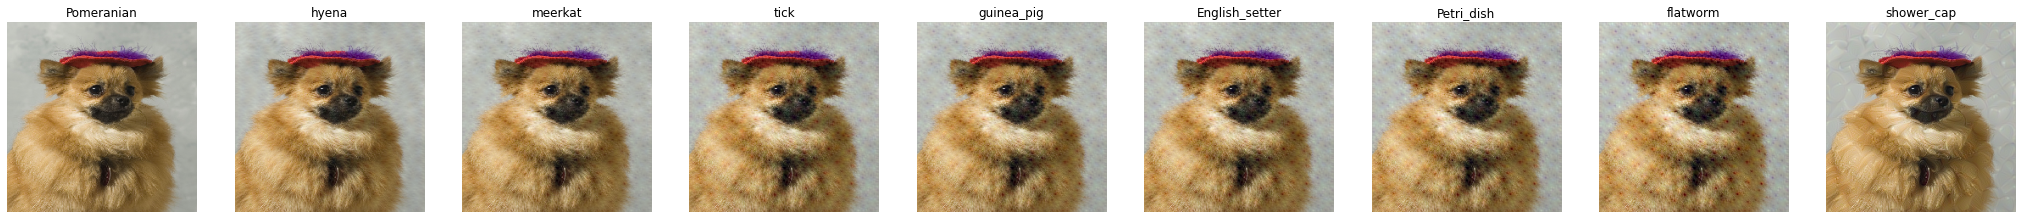

In [21]:
fig, ax = plt.subplots(1, len(archives_adapt[0].found_labels), figsize=(len(archives_adapt[0].found_labels) * 4, 4))
for i, label in enumerate(archives_adapt[0].found_labels.keys()):
    ax[i].set_axis_off()
    ax[i].title.set_text(str(label))
    im = np.array(archives_adapt[0].inputs[label][0]).reshape((224, 224, 3))
    im[:, :, 0] += 103.937
    im[:, :, 1] += 116.779
    im[:, :, 2] += 123.68
    im = im[:, :, ::-1]
    ax[i].imshow(im.clip(0, 255).astype(int))
plt.show()